In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [19]:
agilent = pd.read_csv('../cnv_data/NA12878.WES.agilent_v5.hg38.binned_coverage.bed', sep='\t', header=None, names=['chr', 'start', 'end', 'depth'], index_col=None)
ice = pd.read_csv('../cnv_data/NA12878.WES.ice.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])
twist = pd.read_csv('../cnv_data/NA12878.WES.twist.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])
unknown = pd.read_csv('../cnv_data/NA12878.WES.unknown_v1.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])


In [20]:
phase1_2 = pd.read_csv('../cnv_data/NA12878.WES.phase1_2.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])
phase3 = pd.read_csv('../cnv_data/NA12878.WES.phase3.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])



In [21]:
phase1_2[phase1_2['depth'] > 100]

,chr,start,end,depth
0,chr1,69091,69290,4217
1,chr1,69291,69490,2633
2,chr1,69491,69690,2153
3,chr1,69691,70008,10410
4,chr1,925941,926013,364
...,...,...,...,...
18526,chr1,248917202,248917401,1342
18527,chr1,248917402,248917601,1308
18528,chr1,248917602,248917801,1072
18529,chr1,248917802,248918001,531


In [22]:
all_bed = {'agilent': agilent, 'ice': ice, 'twist': twist, 'unknown': unknown, 'phase1_2':phase1_2, 'phase3':phase3}
for name, b in all_bed.items():
    b['length'] = b['end'] - b['start']
    b['depth_norm'] = b.apply(lambda x: np.NaN if x['length'] == 0 else x['depth'] * 76 / x['length'], axis=1)

In [36]:
{name: bed['depth_norm'].mean() for name, bed in all_bed.items()}

{'agilent': 232.88153672514696,
 'ice': 360.19562028624074,
 'twist': 361.2537876855153,
 'unknown': 86.09078741474406,
 'phase1_2': 403.3466733676452,
 'phase3': 272.61227044992427}

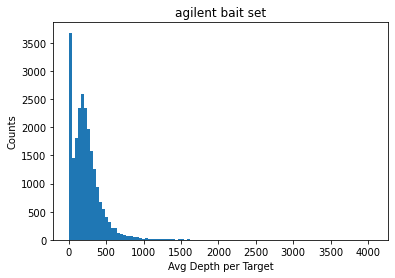

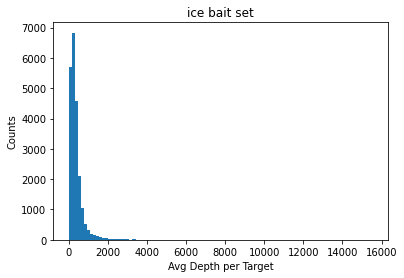

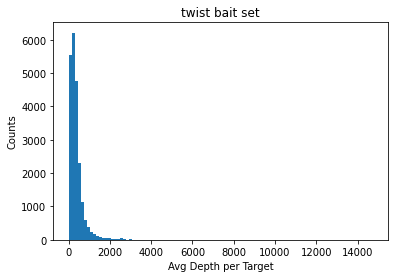

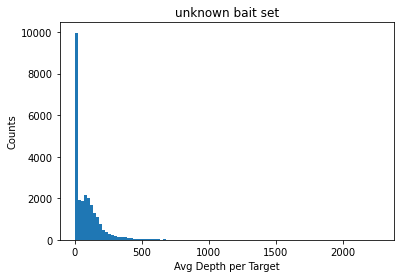

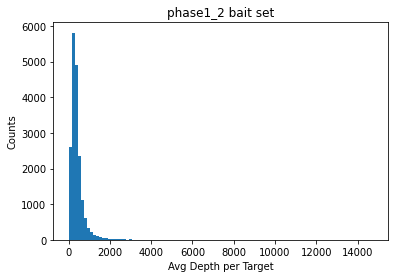

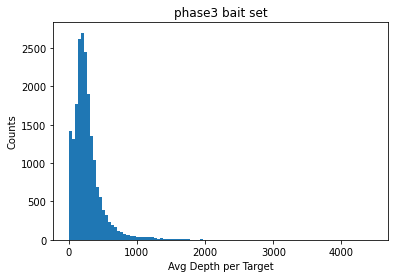

In [24]:
for name, b in all_bed.items():
    fig = plt.hist(b['depth_norm'], 100)
    plt.title(f"{name} bait set")
    plt.xlabel('Avg Depth per Target')
    plt.ylabel('Counts')
    plt.show()

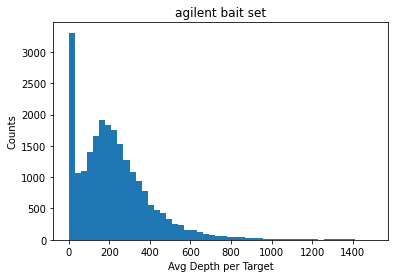

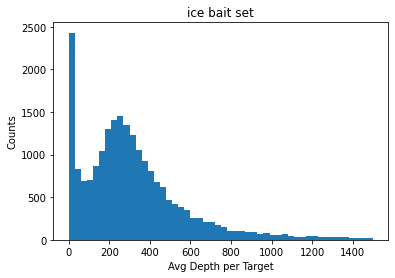

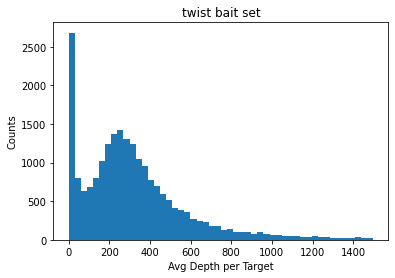

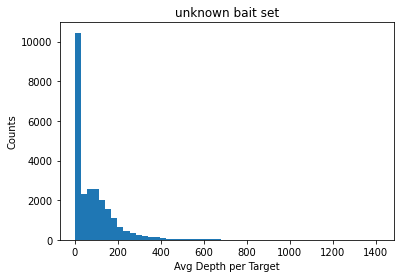

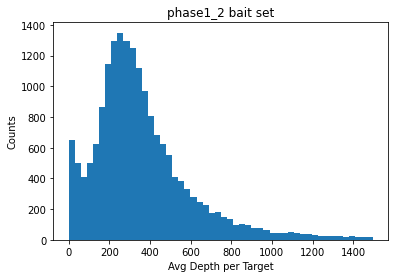

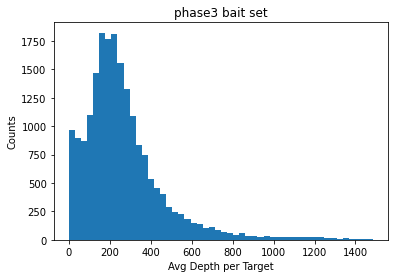

In [25]:
for name, b in all_bed.items():
    fig = plt.hist(b[b['depth_norm'] < 1500]['depth_norm'], 50)
    plt.title(f"{name} bait set")
    plt.xlabel('Avg Depth per Target')
    plt.ylabel('Counts')
    plt.show()

(0.0, 1500.0)

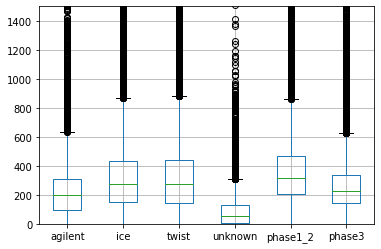

In [45]:
depth_list = []
for name, b in all_bed.items():
    depth_list.append(list(b['depth_norm']))

df = pd.DataFrame(data = depth_list, index = all_bed.keys())
df.transpose().boxplot()
ax = plt.gca()
ax.set_ylim([0,1500])

In [41]:
for name, b in all_bed.items():
    print(f'{name}: {len(b[b["depth_norm"] < 5])}')

agilent: 1273
ice: 778
twist: 862
unknown: 6840
phase1_2: 158
phase3: 194


### It seems that the Phase 1/2 consensus target file matches our WES file the best

## Now investigate bam vs. Solexa/Pond bams

In [3]:
full_bam_snp_depths = pd.read_csv('../cnv_data/NA12878_WES.vcf.depths.bed', sep='\t')
solexa_bam_snp_depths = pd.read_csv('../cnv_data/NA12878_Solexa_WES.vcf.depths.bed', sep='\t')
pond_bam_snp_depths = pd.read_csv('../cnv_data/NA12878_Pond_WES.vcf.depths.bed', sep='\t')


In [8]:
combo_depths = full_bam_snp_depths.merge(solexa_bam_snp_depths, on=['chr', 'pos'], suffixes=['_full', '_solexa']).merge(pond_bam_snp_depths, on=['chr', 'pos']).rename(columns={'depth': 'depth_pond'})

In [10]:
combo_depths.set_index(['chr', 'pos'], inplace=True)

In [18]:
combo_depths['depth_combo'] = combo_depths['depth_solexa'] + combo_depths['depth_pond']

In [66]:
combo_depths[(combo_depths['depth_combo'] - combo_depths['depth_full']) > 3]

depth_full  depth_solexa  depth_pond  depth_combo
chr  pos                                                         
chr1 790933             17            20           1           21
     866563              9            12           1           13
     873251             11             7           9           16
     873542            156           131         111          242
     873548            159           129         114          243
...                    ...           ...         ...          ...
chrX 155292770          17            20           9           29
     155491696          65            42          46           88
     155524242          12            11           6           17
     155545002          22            32           8           40
     155545046          52            60          31           91

[90625 rows x 4 columns]

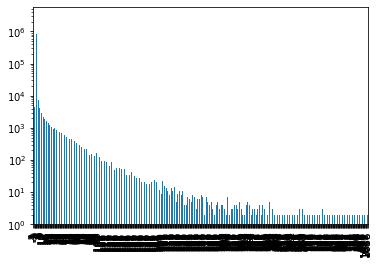

In [54]:
ax = (combo_depths['depth_combo'] - combo_depths['depth_full']).value_counts().sort_index().plot.bar(log=True)


Text(0, 0.5, 'Number of SNVs')

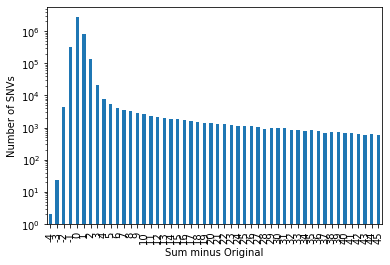

In [60]:
ax = (combo_depths['depth_combo'] - combo_depths['depth_full']).value_counts().sort_index().iloc[0:50].plot.bar(log=True)
ax.set_xlabel('Sum minus Original')
ax.set_ylabel('Number of SNVs')

In [32]:
combo_depths[combo_depths['depth_full'] > 10].describe()

,depth_full,depth_solexa,depth_pond,depth_combo
count,91543.000000,91543.000000,91543.000000,91543.000000
mean,63.095780,56.659810,40.260664,96.920475
std,75.001582,81.322035,51.693131,123.516204
min,11.000000,0.000000,0.000000,9.000000
25%,20.000000,17.000000,10.000000,28.000000
50%,41.000000,35.000000,24.000000,60.000000
75%,82.000000,71.000000,53.000000,125.000000
max,4832.000000,7218.000000,1850.000000,7282.000000


In [24]:
! samtools view -c ../cnv_data/NA12878.alt_bwamem_GRCh38DH.20150826.CEU.exome.bam

335417841


In [ ]:
! samtools view -c ../cnv_data/NA12878.alt_bwamem_GRCh38DH.20150826.CEU.exome_Pond.bam  # 91052397

In [ ]:
! samtools view -c ../cnv_data/NA12878.alt_bwamem_GRCh38DH.20150826.CEU.exome_Solexa-51024.bam  # 244365444

In [30]:
244365444 + 91052397

335417841

The two split bams (Pond and Solexa) do indeed have the correct number of reads, summing to the count for the whole bam. Why then are there certain loci that have a higher read depth? Because I used the cram to get the depths the first time. There is a bug where the cram reports different (generally lower) read depths. Not sure why, but the filtering must be different. I am re-running on the bam, and that should be totally concordant with the sum of Pond + Solexa.

### After rerunning the depths workflow using the bams (not crams)

In [2]:
full_bam_snp_depths = pd.read_csv('../cnv_data/NA12878_WES.vcf.depths.bed', sep='\t')
solexa_bam_snp_depths = pd.read_csv('../cnv_data/NA12878_Solexa_WES.vcf.depths.bed', sep='\t')
pond_bam_snp_depths = pd.read_csv('../cnv_data/NA12878_Pond_WES.vcf.depths.bed', sep='\t')

In [3]:
combo_depths = full_bam_snp_depths.merge(solexa_bam_snp_depths, on=['chr', 'pos'], suffixes=['_full', '_solexa']).merge(pond_bam_snp_depths, on=['chr', 'pos']).rename(columns={'depth': 'depth_pond'})
combo_depths.set_index(['chr', 'pos'], inplace=True)
combo_depths['depth_combo'] = combo_depths['depth_solexa'] + combo_depths['depth_pond']



In [5]:
combo_depths[(combo_depths['depth_combo'] - combo_depths['depth_full']) != 0]

depth_full  depth_solexa  depth_pond  depth_combo
chr  pos                                                        
chr3 93470446        6745          6740          39         6779
     93470523        7214          7218          64         7282
     93470569        6627          6623          75         6698

After re-running the depth workflow, there are only three positions where the combined Solexa + Pond do not equal the Full bam depth. These positions probably got corrupted somehow. But 3 out of 4167898 is fine

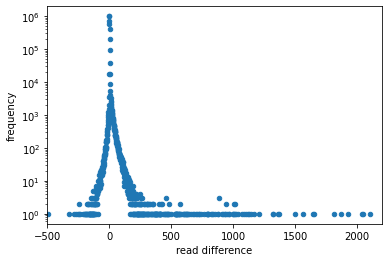

In [37]:
ax = (combo_depths['depth_solexa'] - combo_depths['depth_pond']).value_counts().sort_index().reset_index().rename(columns={'index':'read difference', 0:'frequency'}).plot.scatter(x='read difference', y='frequency', logy=True, xlim=[-500, 2200]) #, xticks=[-20, 0, 20, 40, 60, 80])


<AxesSubplot:xlabel='difference', ylabel='depth_full'>

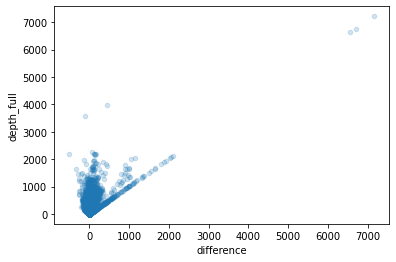

In [39]:
combo_depths['difference'] = combo_depths['depth_solexa'] - combo_depths['depth_pond']
combo_depths.plot.scatter(x='difference', y='depth_full', alpha=0.2)

It does seem that Solexa has more reads (the distribution of the differences is skewed towards the right), however most of the SNPs have approximately an equal number of reads in the Solexa and Pond bams. Most of the outlier Solexa SNPs seem that there is no coverage in the Pond bam (x=y line for difference and full depth). But the remainder are fairly normally distributed (with slight skew towards Solexa). We should use Solexa for the "Tumor" sample.

In [40]:
combo_depths.describe()

,depth_full,depth_solexa,depth_pond,depth_combo,difference
count,4.167898e+06,4.167898e+06,4.167898e+06,4.167898e+06,4.167898e+06
mean,4.358883e+00,3.414548e+00,9.443765e-01,4.358924e+00,2.470171e+00
std,2.302164e+01,1.454873e+01,9.671428e+00,2.303410e+01,8.935024e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.960000e+02
25%,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
50%,2.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00
75%,3.000000e+00,3.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00
max,7.214000e+03,7.218000e+03,1.850000e+03,7.282000e+03,7.154000e+03


It seems that the majority of the Pond SNPs have 0 coverage??? Maybe it won't work as a normal? Oh wait, the Solexa/Full have <3 depth for 75% of the SNPs, because these are exons. I should filter this down to just look at higher coverage areas.

In [86]:
combo_depths[combo_depths['depth_full'] > 10].describe()

,depth_full,depth_solexa,depth_pond,depth_combo,difference
count,102910.00000,102910.000000,102910.000000,102910.000000,102910.000000
mean,87.61683,51.417316,36.201195,87.618511,15.216121
std,119.35385,78.133222,50.104378,119.449935,54.426198
min,11.00000,0.000000,0.000000,11.000000,-496.000000
25%,22.00000,14.000000,7.000000,22.000000,3.000000
50%,50.00000,29.000000,20.000000,50.000000,10.000000
75%,114.00000,65.000000,48.000000,114.000000,20.000000
max,7214.00000,7218.000000,1850.000000,7282.000000,7154.000000


### Investigate the binned coverage (on Exons)

In [45]:
full_bam_exon_depths = pd.read_csv('../cnv_data/NA12878.WES.phase1_2_combined.hg38.binned_coverage.bed', sep='\t', header=None, names=['chr', 'start', 'end', 'cov', 'covraw'])
solexa_bam_exon_depths = pd.read_csv('../cnv_data/NA12878.Solexa_WES.phase1_2_combined.hg38.binned_coverage.bed', sep='\t', header=None, names=['chr', 'start', 'end', 'cov', 'covraw'])
pond_bam_exon_depths = pd.read_csv('../cnv_data/NA12878.Pond_WES.phase1_2_combined.hg38.binned_coverage.bed', sep='\t', header=None, names=['chr', 'start', 'end', 'cov', 'covraw'])

In [52]:
combined_exon_depths = full_bam_exon_depths.drop(columns='covraw').rename(columns={'cov':'cov_full'}).merge(solexa_bam_exon_depths.drop(columns='covraw').rename(columns={'cov':'cov_solexa'}), on=['chr', 'start', 'end']).merge(pond_bam_exon_depths.drop(columns='covraw').rename(columns={'cov':'cov_pond'}), on=['chr', 'start', 'end'])


In [54]:
combined_exon_depths['cov_combined'] = combined_exon_depths['cov_solexa'] + combined_exon_depths['cov_pond']
combined_exon_depths['cov_difference'] = combined_exon_depths['cov_solexa'] - combined_exon_depths['cov_pond']

In [60]:
not_equal = combined_exon_depths[combined_exon_depths['cov_full'] - combined_exon_depths['cov_combined'] != 0]
not_equal

,chr,start,end,cov_full,cov_solexa,cov_pond,cov_combined,cov_difference
1185,chr1,11255992,11256192,23946,13715,10259,23974,3456
2539,chr19,12828869,12828953,21824,13899,8002,21901,5897
4991,chr19,39026870,39027005,59098,37203,21940,59143,15263
7295,chr19,50413742,50413879,29141,17499,11755,29254,5744
10499,chr2,28852408,28852499,21852,8118,13748,21866,-5630
...,...,...,...,...,...,...,...,...
142371,chr17,75874483,75875123,121829,74226,47612,121838,26614
144539,chr18,42057883,42058051,29606,19008,10713,29721,8295
145456,chr19,327864,327989,11213,7099,4289,11388,2810
146468,chr19,5144783,5144902,17922,10498,7474,17972,3024


In [63]:
abs(np.asarray(not_equal['cov_full'] - not_equal['cov_combined'])).mean()

78.17391304347827

The coverage differences are pretty small - only effects 115 exons out of 147654

In [65]:
combined_exon_depths.describe()

,start,end,cov_full,cov_solexa,cov_pond,cov_combined,cov_difference
count,1.476540e+05,1.476540e+05,1.476540e+05,1.476540e+05,1.476540e+05,1.476540e+05,1.476540e+05
mean,7.564929e+07,7.564945e+07,3.782340e+04,2.230044e+04,1.552301e+04,3.782345e+04,6.777430e+03
std,5.566113e+07,5.566113e+07,8.905867e+04,5.284310e+04,3.661330e+04,8.905868e+04,1.828674e+04
min,4.705700e+04,4.706000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.186500e+04
25%,3.331163e+07,3.331175e+07,1.168000e+04,6.288000e+03,4.982000e+03,1.168000e+04,5.010000e+02
50%,6.196074e+07,6.196097e+07,2.359400e+04,1.332400e+04,9.986500e+03,2.359400e+04,3.322000e+03
75%,1.120457e+08,1.120458e+08,4.134975e+04,2.426100e+04,1.729300e+04,4.134975e+04,8.108000e+03
max,2.489139e+08,2.489139e+08,1.324130e+07,7.438584e+06,5.802718e+06,1.324130e+07,1.635866e+06


In [73]:
(combined_exon_depths['end'] - combined_exon_depths['start']).describe()

count    147654.000000
mean        163.775272
std         233.887703
min           1.000000
25%          85.000000
50%         122.000000
75%         169.000000
max       17330.000000
dtype: float64

<AxesSubplot:xlabel='cov_difference', ylabel='cov_full'>

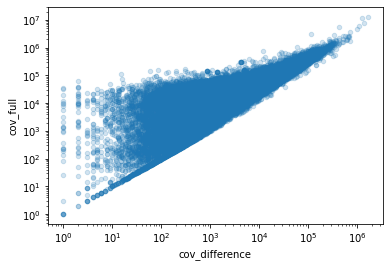

In [67]:
combined_exon_depths.plot.scatter(x='cov_difference', y='cov_full', logx=True, logy=True, alpha=0.2)

In [69]:
only_solexa = combined_exon_depths[(combined_exon_depths['cov_full'] != 0) & (combined_exon_depths['cov_full'] - combined_exon_depths['cov_solexa'] == 0)]
only_solexa                                                  

,chr,start,end,cov_full,cov_solexa,cov_pond,cov_combined,cov_difference
144,chr1,1246514,1246690,98,98,0,98,98
254,chr1,1439766,1439787,21,21,0,21,21
292,chr1,1632219,1632374,34,34,0,34,34
335,chr1,1919044,1919088,176,176,0,176,176
374,chr1,2306577,2306765,587,587,0,587,587
...,...,...,...,...,...,...,...,...
147269,chr19,9835344,9835402,116,116,0,116,116
147278,chr19,9936303,9936366,61,61,0,61,61
147345,chr19,10010298,10010385,90,90,0,90,90
147357,chr19,10096289,10096484,108,108,0,108,108


In [71]:
only_solexa['cov_full'].describe()

count     826.000000
mean      182.786925
std       298.199284
min         1.000000
25%        48.250000
50%        96.000000
75%       229.000000
max      4689.000000
Name: cov_full, dtype: float64

In [72]:
(only_solexa['end'] - only_solexa['start']).describe()

count     826.000000
mean       99.822034
std        90.528381
min         1.000000
25%        49.000000
50%        81.000000
75%       120.000000
max      1257.000000
dtype: float64

There are 826 exons with coverage only in the Solexa bam. But these are all low coverage exons (75% have fewer than 229 coverage). They tend to be slightly smaller than average, but its more that they aren't covered heavily by even the full bam. I think it is probably fine to use the Pond as normal (especially if it is only being used for coverage) but I should discuss with Julian.